In [ ]:
import dask
import dask.dataframe as dd
import pandas as pd
import os
import glob

# 1. 클라이언트 및 대시보드 띄우기
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
client  # 대시보드 링크 확인 (http://127.0.0.1:8787)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 7.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38161,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41497,Total threads: 4
Dashboard: http://127.0.0.1:37771/status,Memory: 1.51 GiB
Nanny: tcp://127.0.0.1:36637,


In [2]:
# 2. 03편에서 쓴 데이터 로드
# (데이터가 없다면 03편의 데이터 생성 코드를 먼저 실행하세요)
data_dir = "dask_data"
df = dd.read_csv(os.path.join(data_dir, "*.csv"))

print(df)

Dask DataFrame Structure:
                  id    value category
npartitions=3                         
               int64  float64   string
                 ...      ...      ...
                 ...      ...      ...
                 ...      ...      ...
Dask Name: to_string_dtype, 2 expressions
Expr=ArrowStringConversion(frame=FromMapProjectable(5b846ad))


In [3]:
# 3개의 파티션이 리스트처럼 들어있습니다.
print(f"총 파티션 개수: {df.npartitions}")

# 0번째 파티션 (첫 번째 CSV 파일)
part_0 = df.partitions[0]
print(f"\n0번째 파티션의 타입: {type(part_0)}")

# 파티션 하나만 compute() 해보기 (작은 pandas DF가 나옴)
df_part_0 = part_0.compute()
print(f"\n0번째 파티션의 실제 데이터 타입: {type(df_part_0)}")
print(f"0번째 파티션의 행 개수: {len(df_part_0)}")

총 파티션 개수: 3

0번째 파티션의 타입: <class 'dask.dataframe.dask_expr._collection.DataFrame'>

0번째 파티션의 실제 데이터 타입: <class 'pandas.core.frame.DataFrame'>
0번째 파티션의 행 개수: 1666666


In [4]:
# 현재 3개 파티션을 6개로 쪼개기
# (데이터를 읽어서 6개로 나누는 '계획'을 세움)
df_repartitioned = df.repartition(npartitions=6)

print(f"재조정된 파티션 개수: {df_repartitioned.npartitions}")

재조정된 파티션 개수: 6


In [5]:
print(df.index)

<dask_expr.expr.Index: expr=Index(frame=ArrowStringConversion(frame=FromMapProjectable(5b846ad)))>


In [ ]:
df.loc[123456].compute()  # 파티션 당 하나

,id,value,category
123456,123456,12345.6,B
123456,1790122,24691.2,B
123456,3456788,37036.8,B


In [7]:
%%time

# 'id' 컬럼을 새 인덱스로 설정하라고 '계획'
df_indexed_plan = df.set_index('id')

print("--- .persist() 시작 (대시보드 집중!) ---")
# 실제 셔플(정렬)이 일어나는 순간
df_indexed = df_indexed_plan.persist()
print("--- .persist() 완료 ---")

--- .persist() 시작 (대시보드 집중!) ---
--- .persist() 완료 ---
CPU times: user 77.1 ms, sys: 8.47 ms, total: 85.6 ms
Wall time: 779 ms


In [8]:
print(df_indexed.index)
# Known=True로 바뀜 (Dask가 인덱스 구조를 앎)

print(f"\n0번 파티션의 시작/끝: {df_indexed.divisions[0]}, {df_indexed.divisions[1]}")
print(f"1번 파티션의 시작/끝: {df_indexed.divisions[1]}, {df_indexed.divisions[2]}")

<dask_expr.expr.Index: expr=Index(frame=FromGraph(bc667f8))>

0번 파티션의 시작/끝: 0, 1666666
1번 파티션의 시작/끝: 1666666, 3333332


In [9]:
%%time
# .loc로 특정 id값 찾기
# (Dask가 정확히 어느 파티션에 가야할지 알기 때문에 '즉시' 끝남)
row = df_indexed.loc[123456].compute()

print(row)

          value category
id                      
123456  12345.6        B
CPU times: user 21 ms, sys: 4.84 ms, total: 25.8 ms
Wall time: 37.3 ms


In [ ]:
# 매니저 정보가 담긴 작은 테이블
df_managers = pd.DataFrame(
    {
        "category": ["A", "B", "C", "D", "E"],
        "manager": ["Alice", "Bob", "Charlie", "David", "Eve"],
    }
)
# 파티션 1개짜리 Dask DF로 변환
dd_managers = dd.from_pandas(df_managers, npartitions=1)

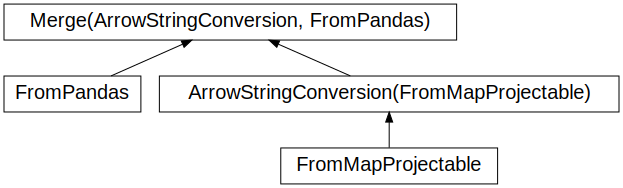

In [ ]:
# 'category'는 인덱스가 아니므로 Dask는 데이터가 어디있는지 모름
merged_bad_plan = dd.merge(df, dd_managers, on="category")

# 시각화: 복잡한 셔플 그래프가 나옴
merged_bad_plan.visualize()

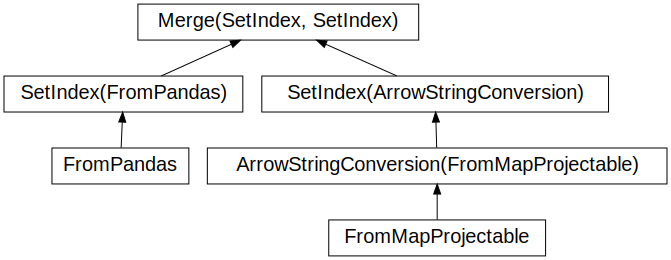

In [ ]:
# 두 DF 모두 'category'를 인덱스로 설정
df_cat_indexed = df.set_index("category")
dd_managers_indexed = dd_managers.set_index("category")

# 'index' 기준으로 merge (left_index=True, right_index=True)
merged_good_plan = dd.merge(
    df_cat_indexed, dd_managers_indexed, left_index=True, right_index=True
)

# 시각화: 훨씬 단순한 그래프가 나옴
merged_good_plan.visualize()